In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd

#torch.manual_seed(1)

Using TensorFlow backend.


In [2]:
def pre_process(data, var):
    
    Q = 60.0  - np.cumsum(data.I)
    data["Q"] = Q/1000
    return data[var]

def windows (data, window_size, stride):
    
    x = np.array(data)
    length = data.shape[0]
    windows_list = []
    
    for i in range(0, length-window_size, stride):
        windows_list.append(x[i:i+window_size][np.newaxis,:])
        
    return tuple(windows_list)


class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    
    def __init__(self, data, window_size, stride, scale = 0, max_list=[]):
        
        x_list = []
        y_list = []
        
        for i in range(0, len(data)-window_size, stride):             
            x_list.append(data[i:i+window_size, 1:][np.newaxis,:])
            #y_list.append(data[i:i+window_size, 0][np.newaxis,:])
            y_list.append(data[i+window_size,0])
        
        self.x = np.vstack(x_list)
        self.y = np.vstack(y_list)
        
        if scale:
           
            self.max_list = max_list
            
        else:
            self.max_y = np.max(self.y)
            self.max_list = [np.max(np.max(self.x, axis=1), axis=0), self.max_y]
        
        self.x = np.divide(self.x, self.max_list[0])
        self.y = self.y/self.max_list[1]
        
        print("x shape:", self.x.shape)
        print("y shape:", self.y.shape)
 

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.y.shape[0]

    def __add__(self, other):
        return ConcatDataset([self, other])
   

In [3]:

var = ["U", "T", "I", "Q"]
path = "C:/Users/Sebastian/Documents/Data Analytics Master/Semester4-Thesis/Datasets/Battery-data/vw/DataLake/DataLake/0/EH_AgingStatus_0Y_Temp_1_rndLC_p.csv"

In [4]:
data = pd.read_csv(path)
data = pre_process(data, var)
data.head()

,U,T,I,Q
0,4.250048,1.0,0.0,0.06
1,4.250048,1.0,0.0,0.06
2,4.250048,1.0,0.0,0.06
3,4.250048,1.0,0.0,0.06
4,4.250048,1.0,0.0,0.06


In [5]:
stride = 20
window_size = 20
backcast = window_size
batch_size = 500
forecast = 1
train_split = int(len(data)*0.6)
val_split = int(len(data)*0.8)
batch_size = 1024
seq_len = backcast
output_dim = forecast
input_dim = 3
n_layers = 2
hidden_dim = 15

In [6]:
data = np.array(data)

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

idx = np.arange(len(data))

#dont apply it for time series
#np.random.shuffle(idx)

train_idx = idx[:train_split]
val_idx = idx[train_split:val_split]
test_idx = idx[val_split:]

train_dataset = Dataset(data[train_idx], window_size, stride)
train_loader = DataLoader(train_dataset, **params)
train_iter = iter(train_loader)

test_dataset = Dataset(data[test_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
test_loader = DataLoader(test_dataset, **params)
test_iter = iter(test_loader)

val_dataset = Dataset(data[val_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
val_loader = DataLoader(val_dataset, **params)
val_iter = iter(val_loader)

x shape: (8527, 20, 3)
y shape: (8527, 1)
x shape: (2842, 20, 3)
y shape: (2842, 1)
x shape: (2842, 20, 3)
y shape: (2842, 1)


In [7]:
# design network
model = Sequential()
model.add(LSTM(hidden_dim, input_shape=(train_dataset.x.shape[1], train_dataset.x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_dataset.x, train_dataset.y, epochs=20, batch_size=128, validation_data=(test_dataset.x, test_dataset.y), verbose=2, shuffle=False)
# plot history






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8527 samples, validate on 2842 samples
Epoch 1/20





 - 4s - loss: 0.2896 - val_loss: 0.0141
Epoch 2/20
 - 2s - loss: 0.0511 - val_loss: 0.0134
Epoch 3/20
 - 2s - loss: 0.0359 - val_loss: 0.0135
Epoch 4/20
 - 2s - loss: 0.0322 - val_loss: 0.0130
Epoch 5/20
 - 2s - loss: 0.0303 - val_loss: 0.0135
Epoch 6/20
 - 2s - loss: 0.0284 - val_loss: 0.0144
Epoch 7/20
 - 2s - loss: 0.0290 - val_loss: 0.0148
Epoch 8/20
 - 2s - loss: 0.0209 - val_loss: 0.0131
Epoch 9/20
 - 2s - loss: 0.0204 - val_loss: 0.0144
Epoch 10/20
 - 2s - loss: 0.0243 - val_loss: 0.0169
Epoch 11/20
 - 2s - loss: 0.0192 - val_loss: 0.0129
Epoch 12/20


KeyboardInterrupt: 

In [8]:
test_dataset.y.shape

(2842, 1)

In [9]:
y_pred = model.predict(train_dataset.x)

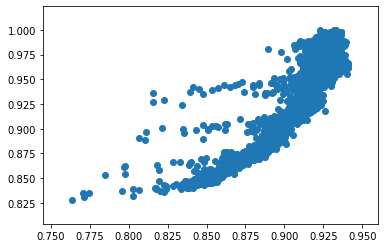

In [10]:
plt.scatter(y_pred, train_dataset.y)

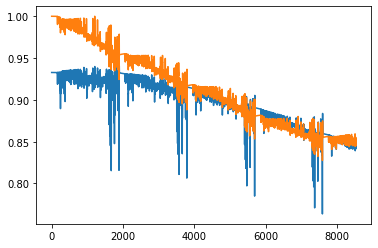

In [11]:
plt.plot(y_pred)
plt.plot(train_dataset.y)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1140      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
_________________________________________________________________
